### Jupyter Notebook to compute morphological metrics from axon and myelin segmentation of a microscopy sample.

- To use it, you need the paths of the microscopy image and the segmentation prediction (output of AxonDeepSeg).


#### Imports

In [1]:
import numpy as np
import math
import os
import matplotlib.pyplot as plt

from AxonDeepSeg.morphometrics.compute_morphometrics import *
import AxonDeepSeg.ads_utils as ads

%matplotlib inline

#### Read image and segmented prediction

In [2]:
# Change the image and segmentation paths here for your sample:
path_img = '/Users/mathieuboudreau/tmp/axondeepseg/AxonDeepSeg/data_test/image.png'
path_pred = '/Users/mathieuboudreau/tmp/axondeepseg/AxonDeepSeg/data_test/AxonDeepSeg.png'

In [3]:
# Read paths and compute axon/myelin masks
img = ads.imread(path_img)
pred = ads.imread(path_pred)
pred_axon = pred > 200
pred_myelin = np.logical_and(pred >= 50, pred <= 200)
path_folder, file_name = os.path.split(path_img)

### Step-by-step use case: extract morphometrics from a segmented microscopy sample

#### 1) Get axon morphometrics

In [4]:
# Compute axon morphometrics
stats_array = get_axon_morphometrics(pred_axon,path_folder)

/Users/mathieuboudreau/anaconda3/envs/ads_pr/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/mathieuboudreau/anaconda3/envs/ads_pr/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


#### 2) Save axon morphometrics and load back

In [5]:
save_axon_morphometrics(path_folder,stats_array)
stats_array = load_axon_morphometrics(path_folder)

#### 3) Extract and plot axon diameter distribution

In [6]:
# Get axon diameter distribution
axon_diam_list = [d['axon_diam'] for d in stats_array]

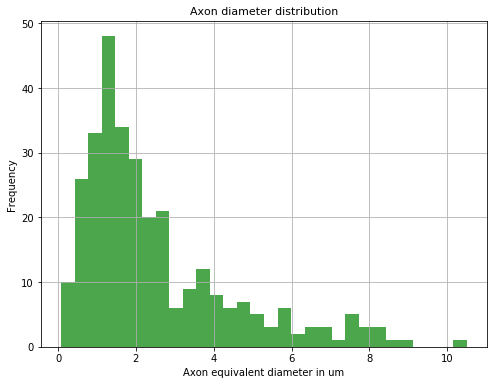

In [7]:
# Plot histogram of axon diameter distribution
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(axon_diam_list,30, facecolor='g', alpha=0.7)
plt.xlabel('Axon equivalent diameter in um',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Axon diameter distribution',fontsize=11)
plt.grid(True)

#### 4) Display boxplots of other axonal morphometrics (example with solidity and eccentricity)

In [8]:
# Get axon solidity distribution (measure of compactness of the axon)
axon_solidity_list = [d['solidity'] for d in stats_array]
# Get axon eccentricity distribution (measure of ellipticity/extent of the axon)
axon_eccentricity_list = [d['eccentricity'] for d in stats_array]

[Text(0, 0, 'Solidity'), Text(0, 0, 'Eccentricity')]

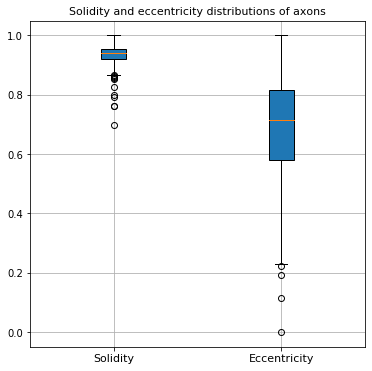

In [9]:
# Plot boxplots of solidity and eccentricity
plt.figure(figsize=(6,6))
data_to_plot = [axon_solidity_list,axon_eccentricity_list]
plt.boxplot(data_to_plot,patch_artist=True)
plt.title('Solidity and eccentricity distributions of axons',fontsize=11)
plt.grid(True)
frame1 = plt.gca()
frame1.set_xticklabels(['Solidity', 'Eccentricity'],fontsize=11)

#### 5) Display and save axon mask overlay labelled for axon diameter

/Users/mathieuboudreau/anaconda3/envs/ads_pr/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/mathieuboudreau/anaconda3/envs/ads_pr/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


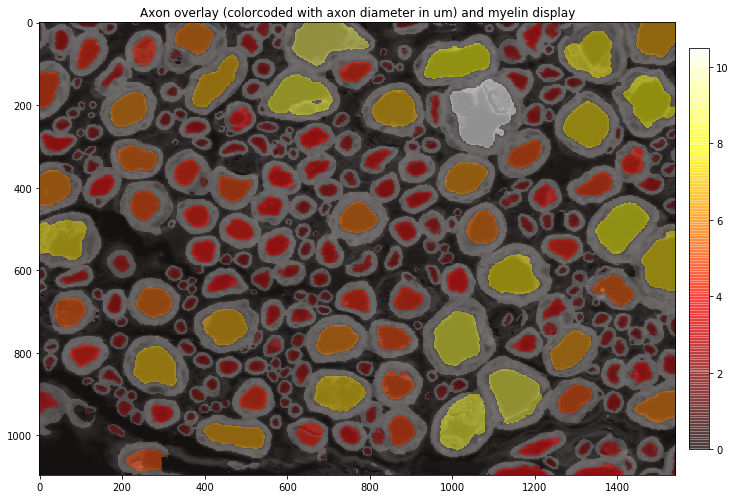

In [10]:
fig = draw_axon_diameter(img,path_pred,pred_axon,pred_myelin)
from IPython.core.display import display
fig.canvas.draw()
display(fig)

#### 6) Compute aggregate axon/myelin morphometrics

In [11]:
# Compute aggregate metrics
aggregate_metrics = get_aggregate_morphometrics(pred_axon,pred_myelin,path_folder)
print(aggregate_metrics)

{'avf': 0.29096662040479926, 'mvf': 0.4019062889298351, 'gratio_aggr': 0.6480295264625788, 'mean_axon_diam': 2.4953111568506747, 'mean_myelin_diam': 3.850613367066646, 'mean_myelin_thickness': 0.6776511051079857, 'axon_density_mm2': 36975.33807784116}


#### 7) Save aggregate metrics

In [12]:
write_aggregate_morphometrics(path_folder,aggregate_metrics)

#### Other useful code snippets

In [13]:
# Show metrics available for axons
print(stats_array[0].keys())

dict_keys(['y0', 'x0', 'axon_diam', 'axon_area', 'solidity', 'eccentricity', 'orientation'])


In [14]:
# Get axon diameter value of axon object 0
print(stats_array[0]['axon_diam'])

1.662474384691872


In [15]:
# Get solidity value of axon object 50
print(stats_array[49]['solidity'])

0.9521158129175946


In [16]:
# Display all stats for axon object 10
print(stats_array[9])

{'y0': 18.277840269966255, 'x0': 1241.2317210348706, 'axon_diam': 2.3550708653500947, 'axon_area': 4.3561000000000005, 'solidity': 0.8881118881118881, 'eccentricity': 0.6605136709145815, 'orientation': 1.113850728904595}


In [17]:
# Get axon diameter value of all axons in list
axon_diam_list = [d['axon_diam'] for d in stats_array]

In [18]:
# Get number of axons in sample
print(np.size(axon_diam_list))

306


In [19]:
# Get mean diameter
mean_diam = np.mean(axon_diam_list)
print(mean_diam)

2.4953111568506747


In [20]:
# Get max diameter
max_diam = np.max(axon_diam_list)
print(max_diam)

10.503131246777555
